<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import pandas_datareader as pdr
import os
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt 
import tensorflow as tf 
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
#Import Data
stockDf = pd.read_csv('MSFT.csv',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Adj Close', 'Volume'])
stockDf['openChange'] = stockDf.Open.pct_change()
stockDf['closeChange'] = stockDf.Close.pct_change()
stockDf['weekday_num'] = pd.DatetimeIndex(stockDf['Date']).weekday
stockDf['month'] = pd.DatetimeIndex(stockDf['Date']).month
stockDf['day'] = pd.DatetimeIndex(stockDf['Date']).day
stockDf['year'] = pd.DatetimeIndex(stockDf['Date']).year
stockDf['display'] = stockDf["month"].map(str)+ "-" + stockDf["year"].map(str)

In [ ]:
[[stockDf]]

In [31]:
(alt.Chart(stockDf).mark_line().encode(x='Date', y='Close').properties(height=400, width=500))

alt.Chart(...)

In [ ]:
closedChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='closeChange', color=alt.value('black')).properties(height=400, width=2000))
openChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='openChange', color=alt.value('green')).properties(height=400, width=2000))
closedChart+openChart

In [ ]:
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=400, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('week(Date):T', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('month(Date):T'), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [32]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(Volume)', color='year').
         properties(height=200  , width=500))
open

alt.Chart(...)

In [33]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

alt.Chart(...)

In [34]:
#Parameters
fromRecord = 50
toRecord = 100
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1

batchSize = 1
timeSteps = 1

In [35]:
#Creating a new Dataframe & Dataset with subset of records 
newDf = pd.DataFrame().assign(Close=stockDf['Close'], CloseChange=stockDf['closeChange'])
newDf = newDf.loc[fromRecord:toRecord]
myDs = newDf.values
myDs = myDs.astype('float32')
newDf.head(5)

,Close,CloseChange
50,69.209999,-0.018715
51,69.800003,0.008525
52,68.489998,-0.018768
53,68.930000,0.006424
54,68.169998,-0.011026


In [36]:
myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)

In [37]:
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]

In [38]:
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], []
    for i in range(len(data) - size - 1):
        batch = data[i:(i + size), 0]
        X.append(batch)
        if indexAlignment == "R":
          Y.append(data[i + size, 0])
        elif indexAlignment == "P":
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0])

    return np.array(X), np.array(Y)

In [39]:
#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize)
X_test, Y_test = batchData(testData, batchSize)

In [40]:
print('Batch Size: ' + str(batchSize))
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

Batch Size: 1
X_Train[0] (Samples): 69
X_Train[1] (Features): 1


In [ ]:
#SKIPPED - Reshape data to normalize it [samples, time steps, features]
X_trainNew = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_testNew = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [ ]:
X_test[0:5]

In [41]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (1,1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
69/69 - 1s - loss: 0.4158 - 979ms/epoch - 14ms/step
Epoch 2/100
69/69 - 0s - loss: 0.2611 - 128ms/epoch - 2ms/step
Epoch 3/100
69/69 - 0s - loss: 0.1700 - 131ms/epoch - 2ms/step
Epoch 4/100
69/69 - 0s - loss: 0.1068 - 113ms/epoch - 2ms/step
Epoch 5/100
69/69 - 0s - loss: 0.0738 - 139ms/epoch - 2ms/step
Epoch 6/100
69/69 - 0s - loss: 0.0601 - 114ms/epoch - 2ms/step
Epoch 7/100
69/69 - 0s - loss: 0.0493 - 111ms/epoch - 2ms/step
Epoch 8/100
69/69 - 0s - loss: 0.0371 - 132ms/epoch - 2ms/step
Epoch 9/100
69/69 - 0s - loss: 0.0286 - 126ms/epoch - 2ms/step
Epoch 10/100
69/69 - 0s - loss: 0.0222 - 123ms/epoch - 2ms/step
Epoch 11/100
69/69 - 0s - loss: 0.0206 - 142ms/epoch - 2ms/step
Epoch 12/100
69/69 - 0s - loss: 0.0171 - 117ms/epoch - 2ms/step
Epoch 13/100
69/69 - 0s - loss: 0.0170 - 118ms/epoch - 2ms/step
Epoch 14/100
69/69 - 0s - loss: 0.0117 - 122ms/epoch - 2ms/step
Epoch 15/100
69/69 - 0s - loss: 0.0140 - 118ms/epoch - 2ms/step
Epoch 16/100
69/69 - 0s - loss: 0.0123 - 106ms/e

In [ ]:
model.summary()

In [42]:
#Redo
train_predict = model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [43]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
#print('X_trainNew: ' + str(len(X_trainNew)))
#print('X_testNew: ' + str(len(X_testNew)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('')
print('train_predict: ' + str(len(train_predict)))
print('Y_hat_train: ' + str(len(Y_hat_train)))
print('test_predict: ' + str(len(test_predict)))
print('Y_hat_test: ' + str(len(Y_hat_test)))

X_train: 69
X_test: 69
Y_train: 1
Y_test: 1

train_predict: 69
Y_hat_train: 69
test_predict: 69
Y_hat_test: 69


In [46]:
#inverse the inverse
Y_hat_train = scaler.inverse_transform(train_predict)
Y_hat_test = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])
#Y_train = scaler.inverse_transform([Y_train])

In [51]:
Y_test = Y_test.reshape(69,1)
Y_train = Y_train.reshape(69,1)

In [ ]:
#SKIPPED
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

ValueError: ignored

In [ ]:
#SKIPPED
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

ValueError: ignored

In [53]:
#Skipped
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

ValueError: ignored

In [ ]:
#SKIPPEDRedo what is this for
Y_hat_train2 = np.reshape(Y_hat_train, newshape = 69)
Y_hat_test2 = np.reshape(Y_hat_test, newshape = 1)

Y_train2 = np.reshape(Y_train, newshape = 69)
Y_test2 = np.reshape(Y_test, newshape = 1)

In [52]:
#Redo
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
1.9821207366570548 

Test RMSE is: 
1.7970628060033398


In [ ]:
#Redo

In [54]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [55]:
#Redo
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

,Actual_Y,Predicted_Y
0,69.209999,66.354897
1,-0.018715,1.610269
2,69.800001,67.073990
3,0.008525,1.610269
4,68.489995,65.480736


NameError: ignored

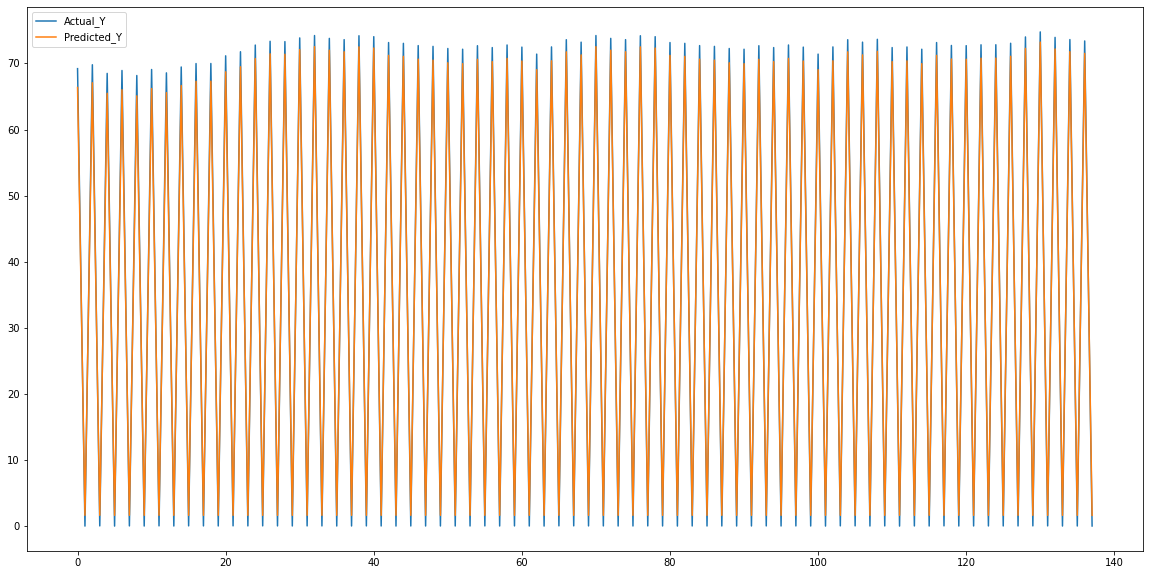

In [56]:
#Redo
result_df.plot(figsize=(20,10))
mplt.xlabel('Time in Days')
mplt.ylabel('Value of Tesla Stock')

In [ ]:
result_df.plot(figsize=(20,10))
mplt.xlabel('Time in Days')
mplt.ylabel('Value of Tesla Stock')